In [13]:
import numpy
import pandas
import nibabel as nib
import SimpleITK as sitk
from datetime import datetime
import cc3d

In [2]:
import matplotlib.pyplot as plt

In [3]:
from ventmapper.segment.ventmapper import *
from ventmapper.deep.predict import *

/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()
Using TensorFlow backend.
/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-

In [4]:
### resampling code
def get_resampled_img(itk_image, out_size=None, out_spacing=None, is_label=False):
    
    orig_size = itk_image.GetSize()
    orig_spacing = itk_image.GetSpacing()
    
    # determine the approximate output spacing that the image should have
    if out_spacing == None:
        out_spacing = [
            orig_size_i * orig_space_i / out_size_i
            for orig_size_i, orig_space_i, out_size_i
            in zip(orig_size, orig_spacing, out_size)
        ]
    
    if out_size == None:
        out_size = [
            int(np.round(orig_size_i * orig_space_i / out_space_i))
            for (orig_size_i, orig_space_i, out_space_i) 
            in zip(orig_size, orig_spacing, out_spacing)
        ]
    
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())      # sets the output direction cosine matrix...
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)

In [5]:
def predict(test_data, model_json, model_weights):
    json_file = open(model_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = load_old_model_json(loaded_model_json)

    model.load_weights(model_weights)

    print("predicting")
    prediction = model.predict(test_data)
    
    return prediction

In [6]:
def run_pipeline(t1=None, t2=None, fl=None, out=None, force=False):
    # this will run ventmapp3r on my own preprocessed images, specifically just my preprocessed t1 and FLAIR.
    # Nice.
    
    # std orientations, for checking orientation
    r_orient = 'RPI'
    l_orient = 'LPI'
    
    prediction = out + ".nii.gz"
    prediction_std_orient = out + "_std_orient.nii.gz"
    
    if os.path.exists(prediction) and force is False:
        print("\n %s already exists" % prediction)
    else:
        start_time = datetime.now()

        
    ###### - CHOOSE THE MODEL AND LOAD THE WEIGHTS
    # if fl is None or t2 is None:
    if fl is None and t2 is None:
        test_seqs = [t1]
        training_mods = ["t1"]
        model_name = 'vent_t1only'
        print("\n found only t1-w, using the %s model" % model_name)
    elif t2 is None and fl:
        test_seqs = [t1, fl]
        training_mods = ["t1", "flair"]
        model_name = 'vent_t1fl'
        print("\n found the t1-w and FLAIR, using the t1-flair model")
    else:
        test_seqs = [t1, fl, t2]
        training_mods = ["t1", "flair", "t2"]
        model_name = 'vent_multi'
        print("\n found all 3 sequences, using the model with all 3 sequences")
        
    hyper_dir = '.'
    model_json = '%s/models/%s_model.json' % (hyper_dir, model_name)
    model_weights = '%s/models/%s_model_weights.h5' % (hyper_dir, model_name)
    
    assert os.path.exists(model_json), "%s does not exist ... please download and rerun script" % model_json
    assert os.path.exists(model_weights), \
        "%s model does not exist ... please download and rerun script" % model_weights
    
    # loading each image and resampling
    pred_shape = [128, 128, 128]
    test_data = np.zeros((1, len(training_mods), pred_shape[0], pred_shape[1], pred_shape[2]), dtype=np.float32)

    # for each of these, im gonna ingore all of their preprocessing code and just use my files.
    for s, seq in enumerate(test_seqs):
        print(colored("\n pre-processing %s" % os.path.basename(seq).split('.')[0], 'green'))

        # check orient
        seq_ort = "./%s_std_orient.nii.gz" % (os.path.basename(seq).split('.')[0])
        # check orientation
        #cp_orient_seq = check_orient(seq, r_orient, l_orient, seq_ort)
#         cp_orient = False
        
#         if cp_orient:
#             raise ValueError(f"had to cp orient this file {s}:{seq}, not sure what to do here...")
        
        in_seq = seq_ort if os.path.exists(seq_ort) else seq

        img = sitk.ReadImage(in_seq)
        orig_spacing = img.GetSpacing()
        orig_size = img.GetSize()
        
        # my resampling code
        res = get_resampled_img(img, out_size=pred_shape)
        new_spacing = res.GetSpacing()
        
        plt.imshow(sitk.GetArrayFromImage(res)[25])
        plt.show()

        # test_data[0, s, :, :, :] = np.moveaxis(np.swapaxes(sitk.GetArrayFromImage(res), 1, 2), 0, -1)
        # test_data[0, s, :, :, :] = sitk.GetArrayFromImage(res)
        test_data[0, s, :, :, :] = np.moveaxis(sitk.GetArrayFromImage(res), 0, -1)
        
    print(colored("\n generating ventricle segmentation", 'green'))

    pred = predict(test_data=test_data, model_json=model_json, model_weights=model_weights)
    
    # because sitk loads the images differently to numpy, transposed in 1, 2 axis
    # pred = np.swapaxes(np.moveaxis(np.squeeze(pred), -1, 0), 1, 2)
    pred = np.squeeze(pred)
    pred = np.moveaxis(pred, -1, 0)
    pred = sitk.GetImageFromArray(pred)
    pred.SetSpacing(new_spacing)
    
    # resample back
    pred_res = get_resampled_img(pred, out_spacing=orig_spacing, out_size=orig_size)
    
    return pred_res

    #todo: need to put in thresholding? or could do that later on in analysis

In [7]:
def post_process_seg_map(pred_res):
    # the vent mapper algorithm introduces some areas that are not ventricles
    # here I use connected component analysis to isolate the single biggest
    # connected component in the whole brain scan, which visually overlaps reasonably
    # well with the true ventricles and gets rid of the erroneous stuff without
    # getting rid of too much true ventricle
    
    pred = sitk.GetArrayFromImage(pred_res)
    # get rid of the two edges of ones that sometimes occur (from resampling process I think)
    pred[:,:,-1]=0
    pred[:,-1,:]=0
    
    labels_out = cc3d.connected_components(pred>0.5, connectivity=6)
    uniques = np.unique(labels_out)[1:] # skip the background label
    max_label_sum = 0
    max_label = 0
    for label in uniques:
        lsum = np.sum(labels_out == label)
        if lsum > max_label_sum:
            max_label_sum = lsum
            max_label = label
            
    pred = (labels_out == max_label) * 1
    
    pred = sitk.GetImageFromArray(pred)
    pred.SetSpacing(pred_res.GetSpacing())
    
    return pred

In [8]:
domain='C'
domains_path='/home/s2208943/ipdis/data/preprocessed_data/EdData/domain'
core_dir = f"{domains_path}{domain}/imgs/"
files = os.listdir(core_dir)

In [9]:
files[0]

'CVD011_FLAIR.nii.gz'

In [10]:
domains_map = {
    d: [(f"{domains_path}{d}/imgs/{f}", f.split('/')[-1].split('_')[0]) for f in os.listdir(f"{domains_path}{d}/imgs/")
        if "_T1.nii.gz" in f
        and 'BET' not in f
        and 'BIAS_CORR' not in f
        and 'NORMALIZE' not in f
       ]
    for d in ['A', 'B', 'C', 'D']
}

all_files_paths = []
for d in domains_map.keys():
    all_files_paths += domains_map[d]

skipping CVD079
skipping CVD100
skipping CVD152
skipping CVD173
processing: 4: CVD184

 found only t1-w, using the vent_t1only model

 pre-processing CVD184_T1


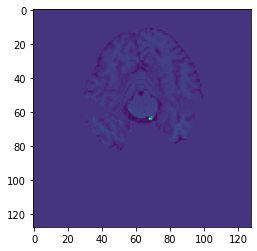


 generating ventricle segmentation

 loading pre-trained model
predicting


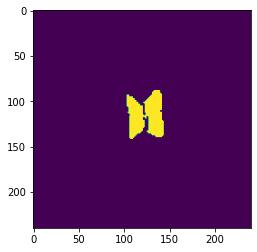

skipping CVD231
skipping CVD018
skipping CVD052
skipping CVD084
processing: 9: CVD085

 found only t1-w, using the vent_t1only model

 pre-processing CVD085_T1


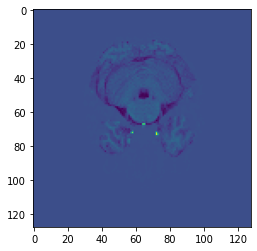


 generating ventricle segmentation

 loading pre-trained model
predicting


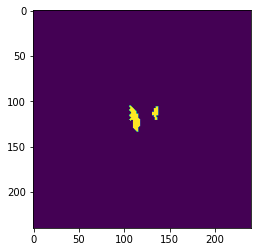

skipping CVD092
skipping CVD134
skipping CVD023
skipping CVD177
skipping CVD181
processing: 15: CVD014

 found only t1-w, using the vent_t1only model

 pre-processing CVD014_T1


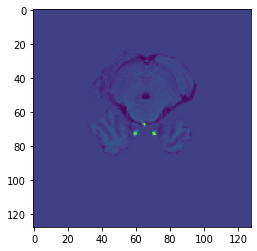


 generating ventricle segmentation

 loading pre-trained model
predicting


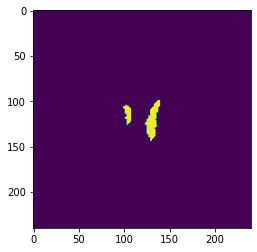

skipping CVD098
skipping CVD115
skipping CVD175
processing: 19: CVD192

 found only t1-w, using the vent_t1only model

 pre-processing CVD192_T1


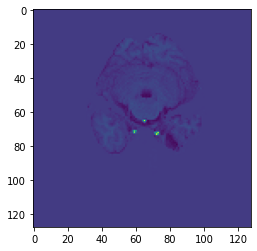


 generating ventricle segmentation

 loading pre-trained model
predicting


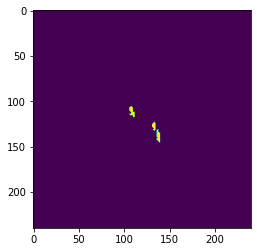

skipping CVD016
skipping CVD024
skipping CVD035
skipping CVD074
skipping CVD041
processing: 25: CVD102

 found only t1-w, using the vent_t1only model

 pre-processing CVD102_T1


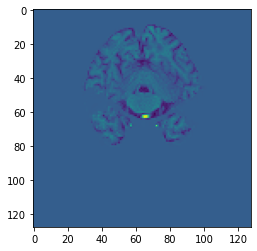


 generating ventricle segmentation

 loading pre-trained model
predicting


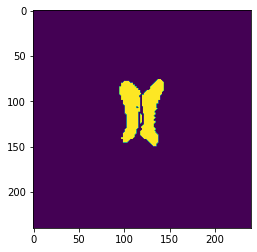

skipping CVD105
skipping CVD219
skipping CVD161
skipping CVD170
skipping CVD225
processing: 31: CVD145

 found only t1-w, using the vent_t1only model

 pre-processing CVD145_T1


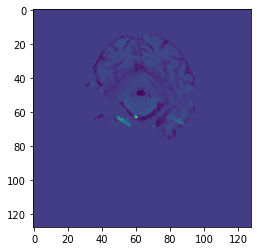


 generating ventricle segmentation

 loading pre-trained model
predicting


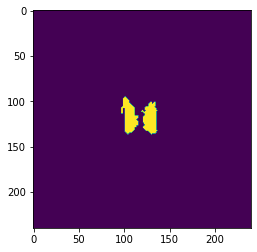

skipping CVD179
skipping CVD229
skipping CVD221
processing: 35: CVD056

 found only t1-w, using the vent_t1only model

 pre-processing CVD056_T1


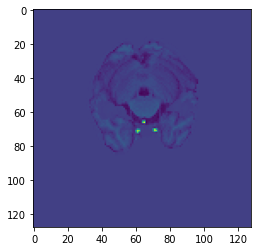


 generating ventricle segmentation

 loading pre-trained model
predicting


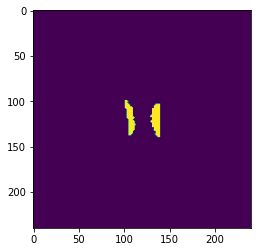

skipping CVD081
skipping CVD088
skipping CVD090
skipping CVD113
skipping CVD118
processing: 41: CVD128

 found only t1-w, using the vent_t1only model

 pre-processing CVD128_T1


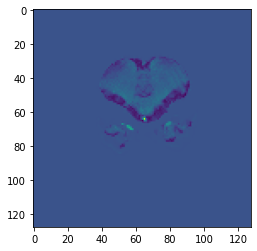


 generating ventricle segmentation

 loading pre-trained model
predicting


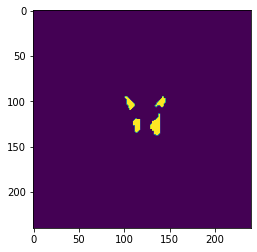

skipping CVD247
skipping CVD195
skipping CVD141
processing: 45: CVD237

 found only t1-w, using the vent_t1only model

 pre-processing CVD237_T1


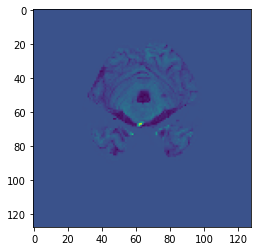


 generating ventricle segmentation

 loading pre-trained model
predicting


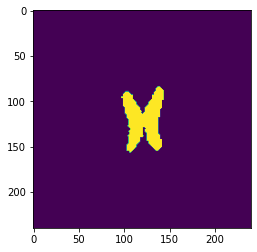

skipping CVD064
skipping CVD077
skipping CVD008
skipping CVD143
skipping CVD245
processing: 51: CVD108

 found only t1-w, using the vent_t1only model

 pre-processing CVD108_T1


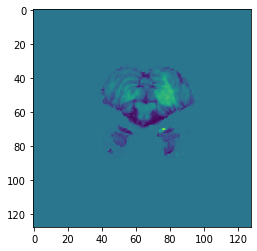


 generating ventricle segmentation

 loading pre-trained model
predicting


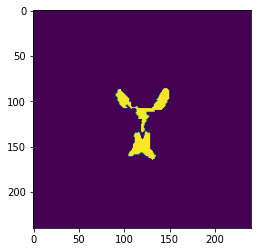

skipping CVD166
skipping CVD031
skipping CVD065
skipping CVD073
skipping CVD111
processing: 57: CVD112

 found only t1-w, using the vent_t1only model

 pre-processing CVD112_T1


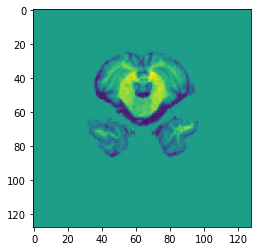


 generating ventricle segmentation

 loading pre-trained model
predicting


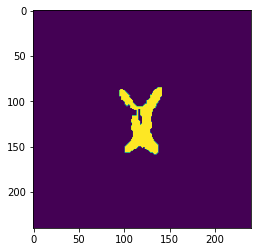

skipping CVD117
skipping CVD158
skipping CVD238
skipping CVD030
skipping CVD127
processing: 63: CVD172

 found only t1-w, using the vent_t1only model

 pre-processing CVD172_T1


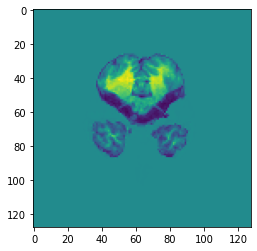


 generating ventricle segmentation

 loading pre-trained model
predicting


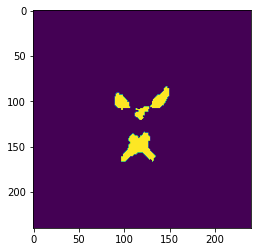

skipping CVD216
skipping CVD004
skipping CVD082
skipping CVD121
skipping CVD188
processing: 69: CVD191

 found only t1-w, using the vent_t1only model

 pre-processing CVD191_T1


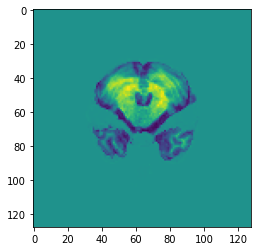


 generating ventricle segmentation

 loading pre-trained model
predicting


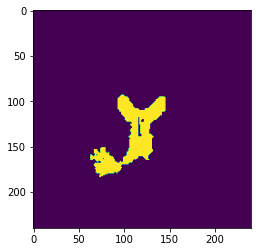

skipping CVD096
skipping CVD012
skipping CVD075
skipping CVD078
skipping CVD083
processing: 75: CVD124

 found only t1-w, using the vent_t1only model

 pre-processing CVD124_T1


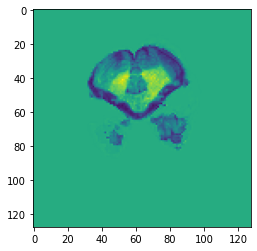


 generating ventricle segmentation

 loading pre-trained model
predicting


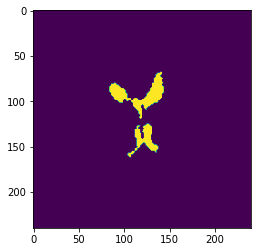

skipping CVD019
skipping CVD048
skipping CVD226
skipping CVD207
skipping CVD208
processing: 81: CVD193

 found only t1-w, using the vent_t1only model

 pre-processing CVD193_T1


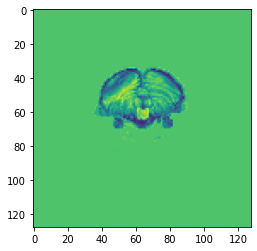


 generating ventricle segmentation

 loading pre-trained model
predicting


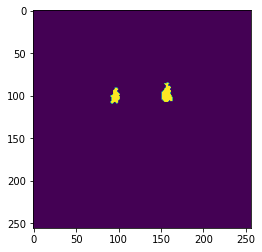

skipping CVD240
skipping CVD204
skipping CVD001
skipping CVD133
skipping CVD003
processing: 87: CVD146

 found only t1-w, using the vent_t1only model

 pre-processing CVD146_T1


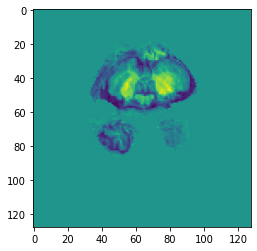


 generating ventricle segmentation

 loading pre-trained model
predicting


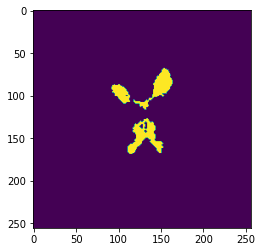

skipping CVD033
skipping CVD213
skipping CVD241
skipping CVD037
skipping CVD013
processing: 93: CVD060

 found only t1-w, using the vent_t1only model

 pre-processing CVD060_T1


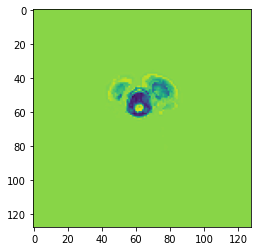


 generating ventricle segmentation

 loading pre-trained model
predicting


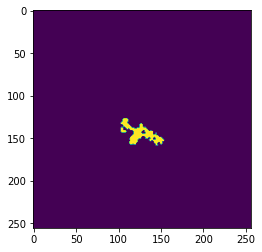

skipping CVD068
skipping CVD076
skipping CVD091
skipping CVD032
skipping CVD107
processing: 99: CVD114

 found only t1-w, using the vent_t1only model

 pre-processing CVD114_T1


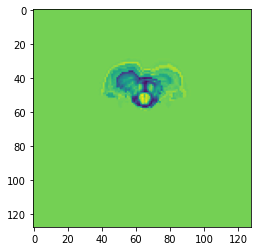


 generating ventricle segmentation

 loading pre-trained model
predicting


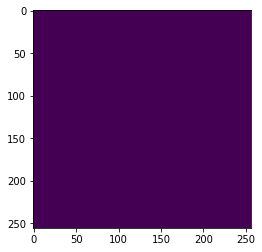

skipping CVD137
skipping CVD040
skipping CVD138
skipping CVD148
skipping CVD047
processing: 105: CVD205

 found only t1-w, using the vent_t1only model

 pre-processing CVD205_T1


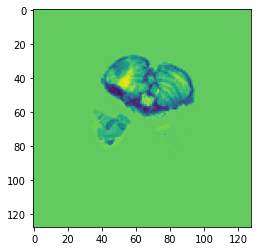


 generating ventricle segmentation

 loading pre-trained model
predicting


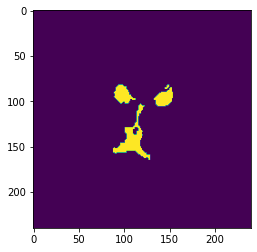

skipping CVD202
skipping CVD042
skipping CVD011
skipping CVD080
skipping CVD028
processing: 111: CVD097

 found only t1-w, using the vent_t1only model

 pre-processing CVD097_T1


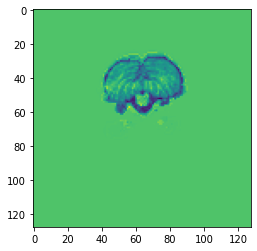


 generating ventricle segmentation

 loading pre-trained model
predicting


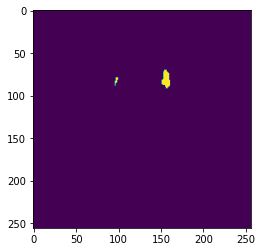

skipping CVD220
skipping CVD140
skipping CVD151
skipping CVD155
skipping CVD178
processing: 117: CVD183

 found only t1-w, using the vent_t1only model

 pre-processing CVD183_T1


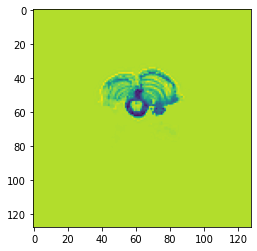


 generating ventricle segmentation

 loading pre-trained model
predicting


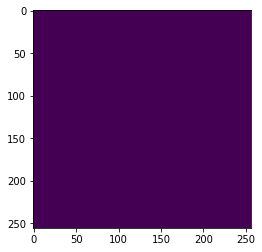

skipping CVD203
skipping CVD061
skipping CVD150
skipping CVD218
skipping CVD206
processing: 123: CVD234

 found only t1-w, using the vent_t1only model

 pre-processing CVD234_T1


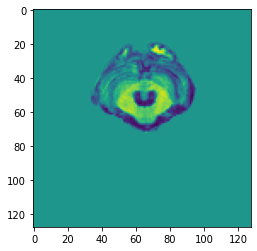


 generating ventricle segmentation

 loading pre-trained model
predicting


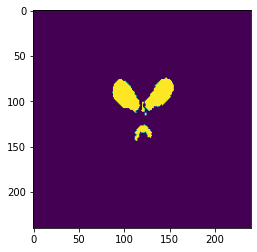

skipping CVD235
skipping CVD246
skipping CVD002
skipping CVD176
skipping CVD017
processing: 129: CVD055

 found only t1-w, using the vent_t1only model

 pre-processing CVD055_T1


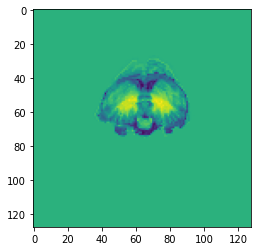


 generating ventricle segmentation

 loading pre-trained model
predicting


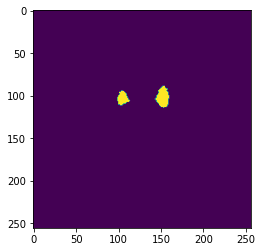

skipping CVD063
skipping CVD025
skipping CVD070
skipping CVD157
skipping CVD038
processing: 135: CVD039

 found only t1-w, using the vent_t1only model

 pre-processing CVD039_T1


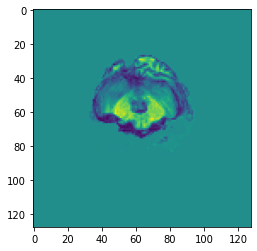


 generating ventricle segmentation

 loading pre-trained model
predicting


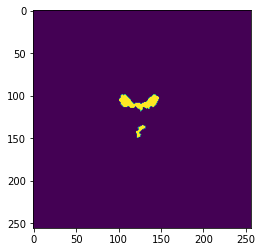

skipping CVD043
skipping CVD200
skipping CVD289
skipping CVD306
skipping CVD021
processing: 141: CVD103

 found only t1-w, using the vent_t1only model

 pre-processing CVD103_T1


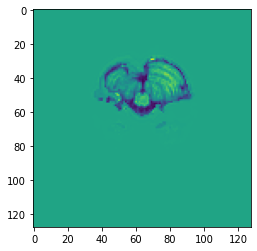


 generating ventricle segmentation

 loading pre-trained model
predicting


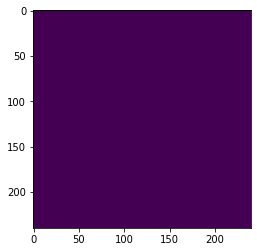

skipping CVD129
skipping CVD130
skipping CVD132
skipping CVD300
skipping CVD214
processing: 147: CVD236

 found only t1-w, using the vent_t1only model

 pre-processing CVD236_T1


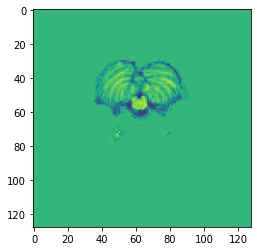


 generating ventricle segmentation

 loading pre-trained model
predicting


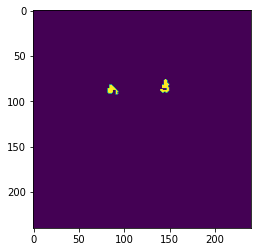

skipping CVD239
skipping CVD262
skipping CVD275
skipping CVD276
skipping CVD284
processing: 153: CVD251

 found only t1-w, using the vent_t1only model

 pre-processing CVD251_T1


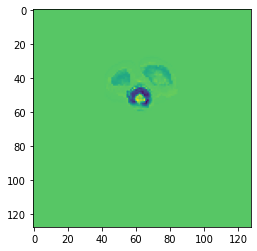


 generating ventricle segmentation

 loading pre-trained model
predicting


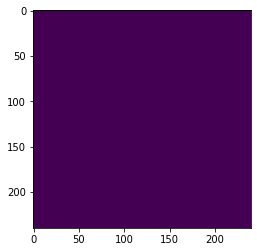

skipping CVD315
skipping CVD318
skipping CVD257
skipping CVD274
processing: 158: CVD282

 found only t1-w, using the vent_t1only model

 pre-processing CVD282_T1


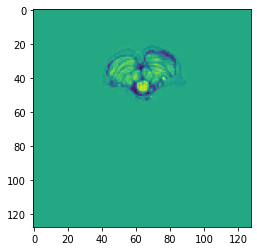


 generating ventricle segmentation

 loading pre-trained model
predicting


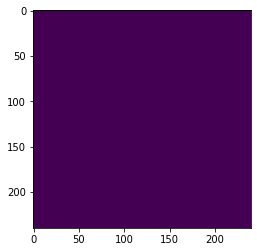

skipping CVD286
skipping CVD304
skipping CVD034
skipping CVD086
skipping CVD089
skipping CVD116
processing: 165: CVD153

 found only t1-w, using the vent_t1only model

 pre-processing CVD153_T1


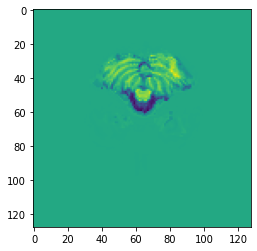


 generating ventricle segmentation

 loading pre-trained model
predicting


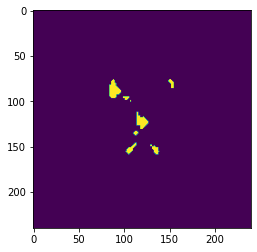

skipping CVD299
skipping CVD167
skipping CVD266
skipping CVD267
processing: 170: CVD273

 found only t1-w, using the vent_t1only model

 pre-processing CVD273_T1


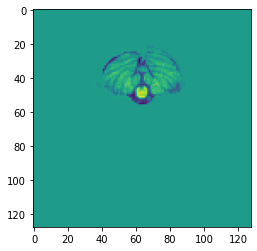


 generating ventricle segmentation

 loading pre-trained model
predicting


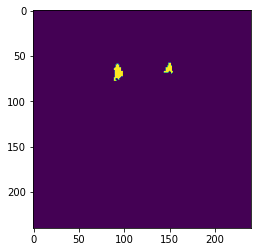

skipping CVD253
skipping CVD194
skipping CVD310
skipping CVD316
skipping CVD323
skipping CVD283
processing: 177: CVD287

 found only t1-w, using the vent_t1only model

 pre-processing CVD287_T1


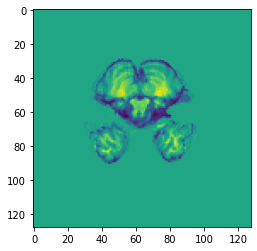


 generating ventricle segmentation

 loading pre-trained model
predicting


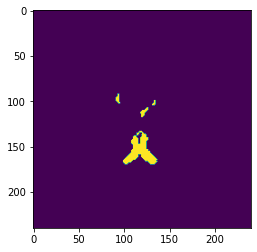

skipping CVD106
skipping CVD288
skipping CVD169
skipping CVD186
processing: 182: CVD268

 found only t1-w, using the vent_t1only model

 pre-processing CVD268_T1


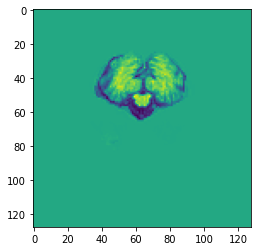


 generating ventricle segmentation

 loading pre-trained model
predicting


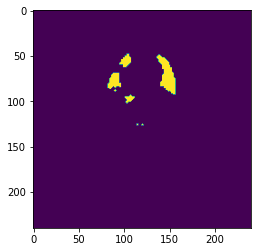

skipping CVD270
skipping CVD272
skipping CVD104
skipping CVD252
skipping CVD009
processing: 188: CVD249

 found only t1-w, using the vent_t1only model

 pre-processing CVD249_T1


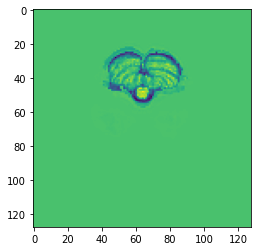


 generating ventricle segmentation

 loading pre-trained model
predicting


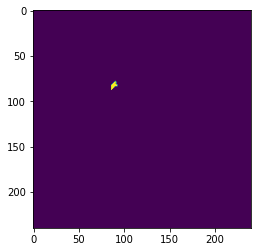

skipping CVD293
skipping CVD294
skipping CVD295
skipping CVD297
skipping CVD301
processing: 194: CVD312

 found only t1-w, using the vent_t1only model

 pre-processing CVD312_T1


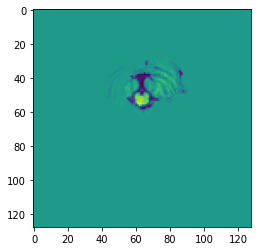


 generating ventricle segmentation

 loading pre-trained model
predicting


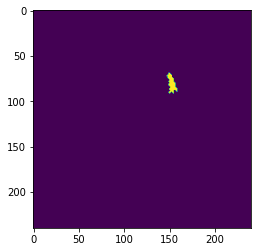

skipping CVD313
skipping CVD314
skipping CVD230
skipping CVD242
processing: 199: CVD258

 found only t1-w, using the vent_t1only model

 pre-processing CVD258_T1


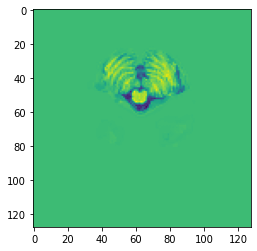


 generating ventricle segmentation

 loading pre-trained model
predicting


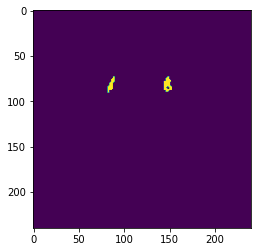

skipping CVD260
skipping CVD264
skipping CVD305
skipping CVD308
skipping CVD309
skipping CVD050
processing: 206: CVD165

 found only t1-w, using the vent_t1only model

 pre-processing CVD165_T1


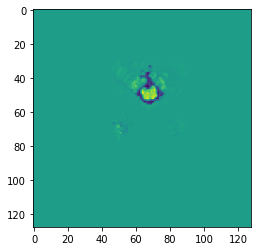


 generating ventricle segmentation

 loading pre-trained model
predicting


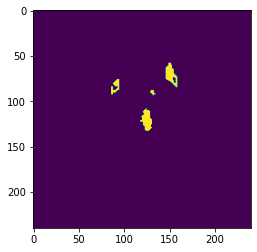

skipping CVD020
skipping CVD296
skipping CVD303
skipping CVD311
processing: 211: CVD319

 found only t1-w, using the vent_t1only model

 pre-processing CVD319_T1


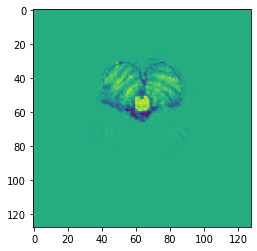


 generating ventricle segmentation

 loading pre-trained model
predicting


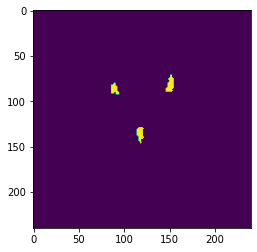

skipping CVD320
skipping CVD322
skipping CVD324
skipping CVD280
skipping CVD291
skipping CVD292
processing: 218: CVD126

 found only t1-w, using the vent_t1only model

 pre-processing CVD126_T1


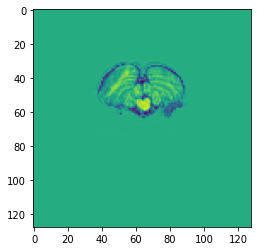


 generating ventricle segmentation

 loading pre-trained model
predicting


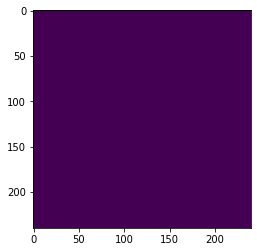

skipping CVD174
skipping CVD259
skipping CVD263
skipping CVD265
processing: 223: CVD156

 found only t1-w, using the vent_t1only model

 pre-processing CVD156_T1


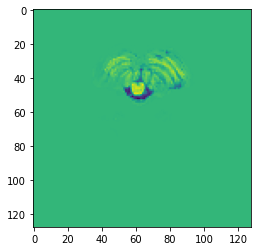


 generating ventricle segmentation

 loading pre-trained model
predicting


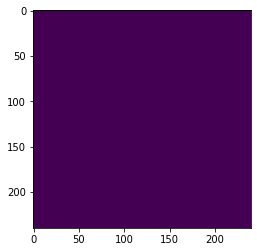

skipping CVD279
skipping CVD248
skipping CVD250
skipping CVD325
processing: 228: CVD049

 found only t1-w, using the vent_t1only model

 pre-processing CVD049_T1


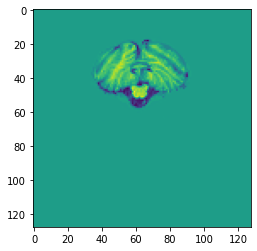


 generating ventricle segmentation

 loading pre-trained model
predicting


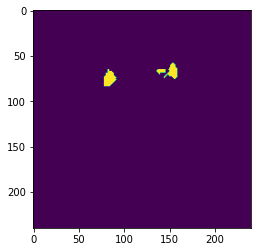

skipping CVD036
skipping CVD171
skipping CVD233
skipping CVD256
skipping CVD261
skipping CVD269
processing: 235: CVD271

 found only t1-w, using the vent_t1only model

 pre-processing CVD271_T1


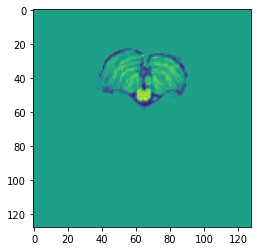


 generating ventricle segmentation

 loading pre-trained model
predicting


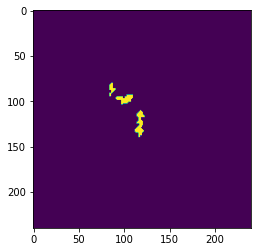

skipping CVD277
skipping CVD278
skipping CVD281
skipping CVD285
processing: 240: CVD290

 found only t1-w, using the vent_t1only model

 pre-processing CVD290_T1


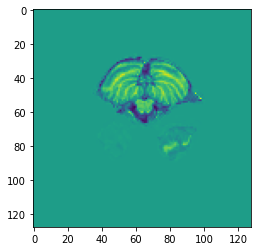


 generating ventricle segmentation

 loading pre-trained model
predicting


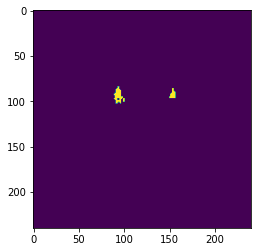

skipping CVD307
skipping CVD254
skipping CVD255
skipping CVD045
skipping CVD298
processing: 246: CVD302

 found only t1-w, using the vent_t1only model

 pre-processing CVD302_T1


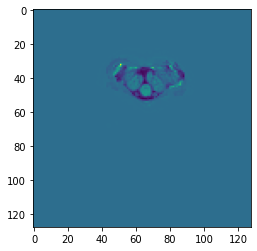


 generating ventricle segmentation

 loading pre-trained model
predicting


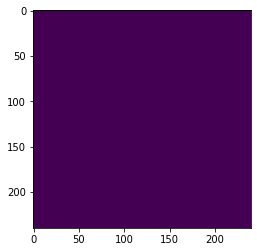

skipping CVD201
skipping CVD317
skipping CVD321


In [14]:
for i, (file_path, ID) in enumerate(all_files_paths):
    final_path = f"/home/s2208943/ipdis/data/preprocessed_data/EdData_ventmapper/{ID}_ventmapper.nii.gz"
    if os.path.exists(final_path):
        print(f"skipping {ID}")
        continue
    else:
        # make a quick temp file so other processes running this notebook don't typically try to compute the same file
        with open(final_path, "w") as temp:
            temp.write("temp")
        
    print(f"processing: {i}: {ID}")
    result = run_pipeline(t1=file_path, fl=None, out="")
    result = post_process_seg_map(result)
    
    plt.imshow(sitk.GetArrayFromImage(result)[25])
    plt.show()
    
    sitk.WriteImage(result, f"/home/s2208943/ipdis/data/preprocessed_data/EdData_ventmapper/{ID}_ventmapper.nii.gz")
    
    

### Check that everything has worked okay

In [ ]:
vmap = sitk.ReadImage(f"/home/s2208943/ipdis/data/preprocessed_data/EdData_ventmapper/CVD325_ventmapper.nii.gz")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 1131
Traceback (most recent call last):
  File "/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-7cf7d6637f9d>", line 1, in <module>
    vmap = sitk.ReadImage(f"/home/s2208943/ipdis/data/preprocessed_data/EdData_ventmapper/CVD325_ventmapper.nii.gz")
  File "/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/SimpleITK/extra.py", line 346, in ReadImage
    return reader.Execute()
  File "/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/SimpleITK/SimpleITK.py", line 8015, in Execute
    return _SimpleITK.ImageFileReader_Execute(self)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/s2208943/miniconda3/envs/ventmapper

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-7cf7d6637f9d>", line 1, in <module>
    vmap = sitk.ReadImage(f"/home/s2208943/ipdis/data/preprocessed_data/EdData_ventmapper/CVD325_ventmapper.nii.gz")
  File "/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/SimpleITK/extra.py", line 346, in ReadImage
    return reader.Execute()
  File "/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/SimpleITK/SimpleITK.py", line 8015, in Execute
    return _SimpleITK.ImageFileReader_Execute(self)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    s

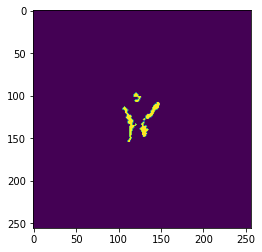

In [553]:
plt.imshow(sitk.GetArrayFromImage(vmap)[34])

In [15]:
len(os.listdir("/home/s2208943/ipdis/data/preprocessed_data/EdData_ventmapper/"))

250

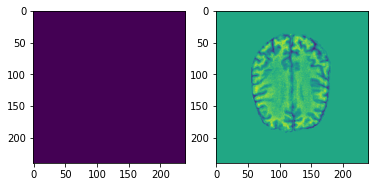

CVD079


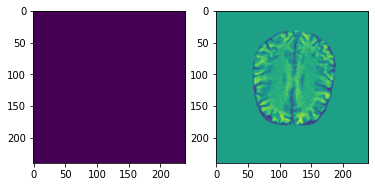

CVD100


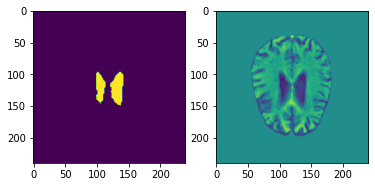

CVD152


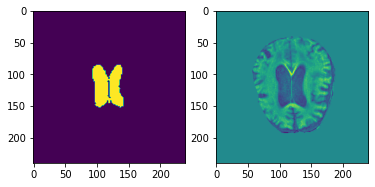

CVD173


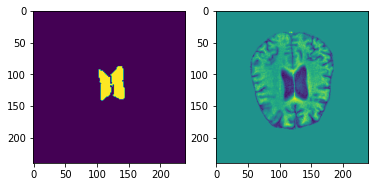

CVD184


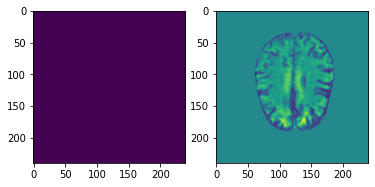

CVD231


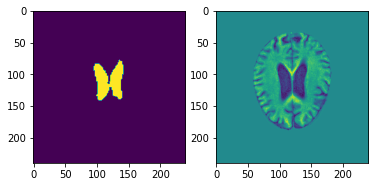

CVD018


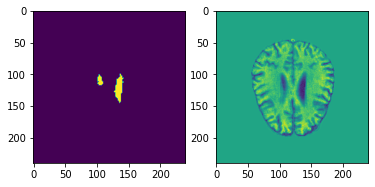

CVD052


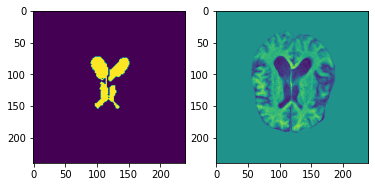

CVD084


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-9505516e1c3d>", line 11, in <module>
    input()
  File "/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 854, in raw_input
    password=False,
  File "/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 895, in _input_request
    raise KeyboardInterrupt("Interrupted by user") from None
KeyboardInterrupt: Interrupted by user

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' ob

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-9505516e1c3d>", line 11, in <module>
    input()
  File "/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 854, in raw_input
    password=False,
  File "/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 895, in _input_request
    raise KeyboardInterrupt("Interrupted by user") from None
KeyboardInterrupt: Interrupted by user

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/s2208943/miniconda3/envs/ventmapper/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' ob

In [ ]:
for i, (file_path, ID) in enumerate(all_files_paths):
    vmap = sitk.ReadImage(f"/home/s2208943/ipdis/data/preprocessed_data/EdData_ventmapper/{ID}_ventmapper.nii.gz")
    tmap = sitk.ReadImage(file_path)
    
    plt.subplot(1,2,1)
    plt.imshow(sitk.GetArrayFromImage(vmap)[25])
    plt.subplot(1,2,2)
    plt.imshow(sitk.GetArrayFromImage(tmap)[25])
    plt.show()
    print(ID)
    input()

yes, all looks good to me

### now, write code for expanding around the ventricles

In [ ]:
# the idea is essentially, just max pool 3d the brain scan until everything inside the mask is selected. see how many times we have to expand, per brain etc. Nice.
# a useful feature for our model would also be the ventricle volume now, along with then intre-cranial volume. Good!